In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import *
from uta import Uta
from norm_layer import NormLayer

PATH = "uta.pt2"

# Data load

In [2]:
# Load data, split into train and test sets and create dataloaders
path = "../Project4/data/mammographic2.csv"
data = pd.read_csv(path, header=None)

num_criteria = 5  # teraz jest 5 cech wejściowych
data_input = data.iloc[:, :num_criteria]
data_target = data.iloc[:, num_criteria]  # ostatnia kolumna jako etykieta

data_input = data_input.values.reshape(-1, 1, num_criteria)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values.astype(int), test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

# Model creation and training

In [3]:
# Create model and train
uta = Uta(num_criteria, 30)
model = NormLayer(uta, num_criteria)
(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(model, train_dataloader, test_dataloader, PATH,epoch_nr=200,lr =0.0001,slope_decrease=True)

100%|██████████| 200/200 [00:02<00:00, 70.34it/s]


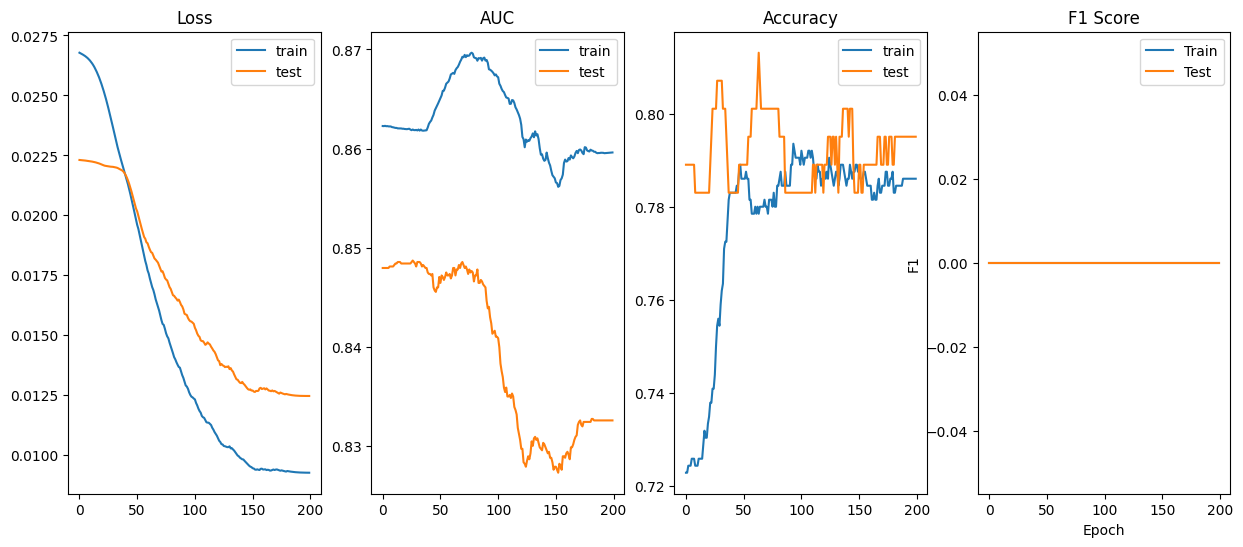

In [8]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(141)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,4,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,4,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()


# F1
ax = fig.add_subplot(1, 4, 4)
ax.plot(stats_train.f1_scores, label='Train')
ax.plot(stats_test.f1_scores, label='Test')
ax.set_title('F1 Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend()

# Ploting marginal value functions of best model

In [5]:
# Load model from checkpoint
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [6]:


hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val,num_criteria)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
# We take every third value becouse the rest are from the normalization layer: velues for 0 and 1
outs = outs[::3] - outs[::3][0]
# Normalize the outputs to get proper weights of the criteria
outs = outs / outs[-1].sum()

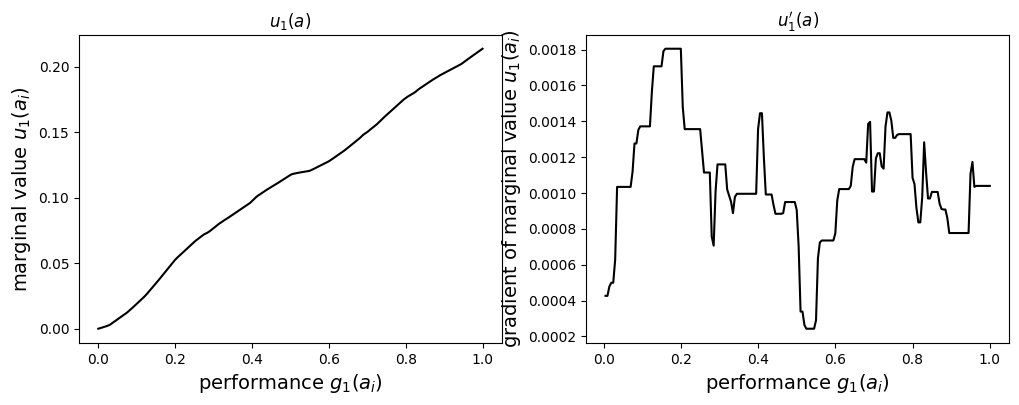

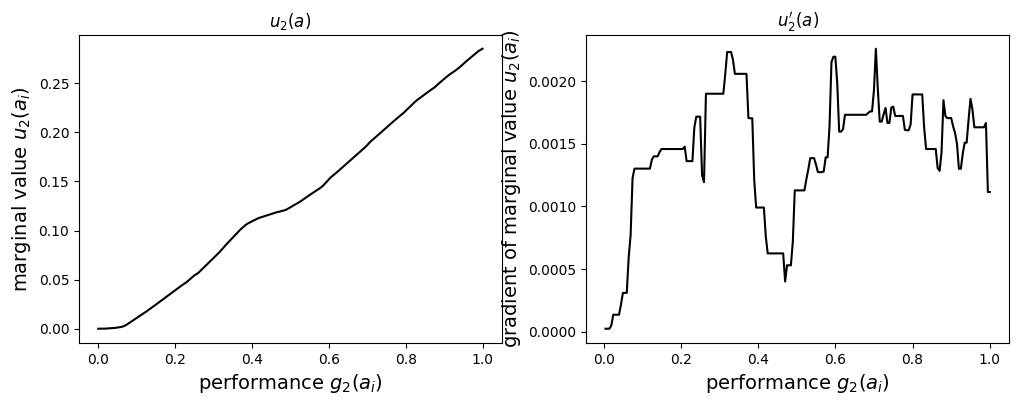

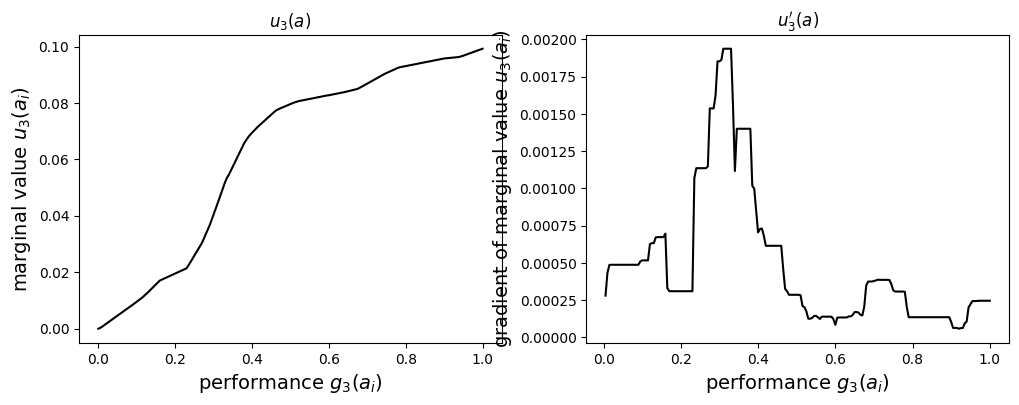

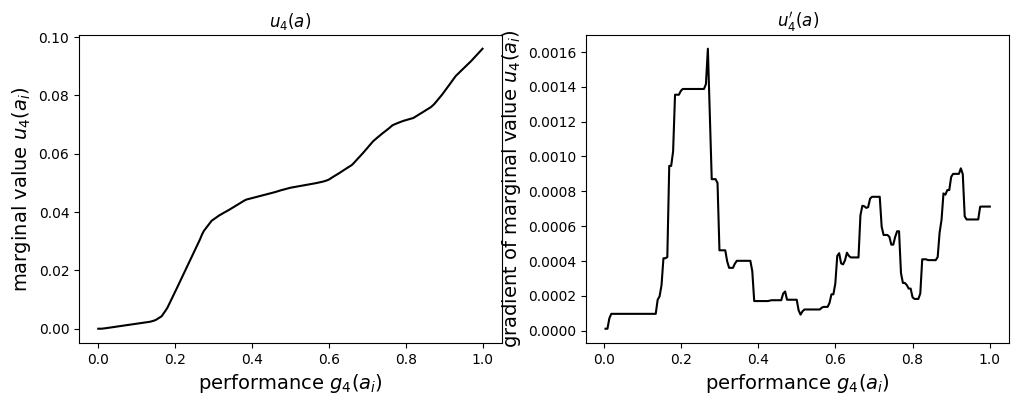

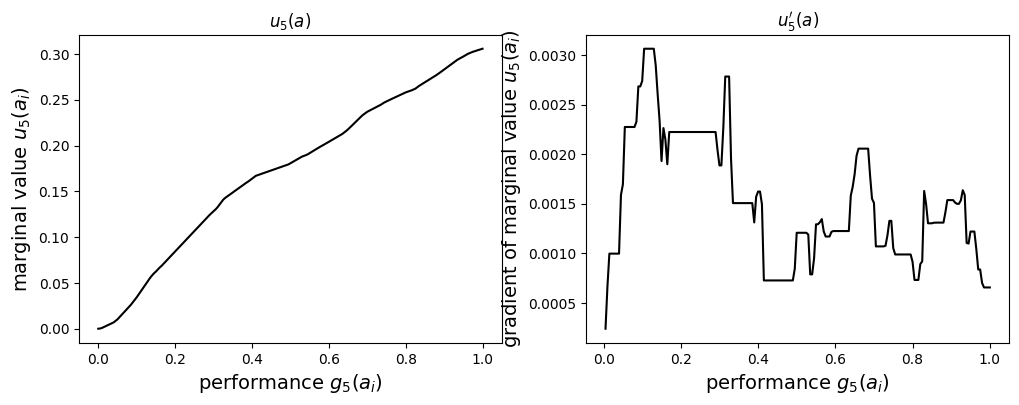

In [7]:
for i in range(num_criteria):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()